In [17]:
def posconocasfavor(id_partido,equipo):

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    pd.options.mode.chained_assignment=None


    matches=pd.read_json('https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/matches/37/42.json')
    matches['union']=range(len(matches))
    
    #Separamos los datos de la columna home_team y le añadimos la columna union
    local1=matches['home_team'].apply(pd.Series)
    local1['union']=range(len(matches))

    #Unimos los dataframes 
    local2=pd.merge(matches, local1,how='outer',on='union')

    #Nos quedamos con la fila correspondiente al partido y seleccionamos el nombre del equipo local para guardarlo en su variable
    fila1=local2.loc[local2['match_id']==id_partido]

    local=fila1.iloc[0,-5]

    #Mismo proceso para equipo visitante
    visit1=matches['away_team'].apply(pd.Series)
    visit1['union']=range(len(matches))
    visit2=pd.merge(matches, visit1,how='outer',on='union')
    fila2=visit2.loc[visit2['match_id']==id_partido]
    visitante=fila2.iloc[0,-5]

    if equipo==local:
        rival=visitante
    elif equipo==visitante:
        rival=local
    
    goleslocal=fila1.iloc[0,7]
    golesvisitante=fila1.iloc[0,8]

    jornada=fila1.iloc[0,12]
    fecha=fila1.iloc[0,1]

    #DF con todos los eventos del partido
    events='https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/events/{}.json'.format(id_partido)
    dfeventos=pd.read_json(events)

    #DF eventos propios
    dfeventos['equipo']=dfeventos['possession_team'].apply(lambda x: x.get('name'))
    dfpropio=dfeventos.loc[dfeventos['equipo']==equipo]

    #DF posesiones propias
    dfposesiones=dfpropio[['possession','timestamp','minute','second']]

    #Obtenemos las duraciones
    dfinicios=dfposesiones.drop_duplicates(subset='possession',keep='first')
    dffinales=dfposesiones.drop_duplicates(subset='possession',keep='last')
    dfexpand=dfinicios.merge(dffinales,how='outer',on='possession')
    dfexpand['duracion']=dfexpand['timestamp_y']-dfexpand['timestamp_x']
    dfexpand['segundos']=dfexpand['duracion'].apply(lambda x: x.seconds)
    dfexpand['second_x']=dfexpand['second_x']/60
    dfexpand['comienzo']=round(dfexpand['minute_x']+dfexpand['second_x'],2)
    dfexpand.drop(columns=['timestamp_x','timestamp_y','minute_y','second_y','minute_x','second_x','duracion'],inplace=True)
    dfexpand.drop(dfexpand[(dfexpand['segundos']) >= 60000].index , inplace=True)

    #DF tiros 
    dfeventos['tipo']=dfeventos['type'].apply(lambda x: x.get('name'))
    dftiros=dfeventos.loc[dfeventos['tipo']=="Shot"]
    dftiroscorto=dftiros[['minute','second','shot','team']]
    dftiroscorto['resultado']=dftiroscorto['shot'].apply(lambda x: x.get('outcome'))
    dftiroscorto['resultado2']=dftiroscorto['resultado'].apply(lambda x: x.get('name'))

    #DF goles
    dfgoles=dftiroscorto.loc[dftiroscorto['resultado2']=="Goal"]
    dfgoles.drop(columns=['shot','resultado','resultado2'],inplace=True)
    dfgoles['equipo']=dfgoles['team'].apply(lambda x:x.get('name'))
    dfgoles.drop(columns=['team'],inplace=True)

    #DF goles en propia
    dfgolespp=dfeventos.loc[(dfeventos['tipo']=="Own Goal For")]
    dfgolesppcorto=dfgolespp[['minute','second','team']]
    dfgolesppcorto['equipo']=dfgolesppcorto['team'].apply(lambda x:x.get('name'))
    dfgolesppcorto.drop(columns=['team'],inplace=True)
    dfgoles=pd.concat([dfgoles,dfgolesppcorto],sort=True)
    dfgoles['golloc']=0
    dfgoles['golvis']=0

    dfgoles.sort_index(inplace=True)

    posicioncolumnaequipo=dfgoles.columns.get_loc("equipo")

    for i in range(len(dfgoles)):
        if dfgoles.iloc[i,posicioncolumnaequipo]==local:
            dfgoles.iloc[i,3]+=1
            for a in range(i+1,len(dfgoles)):
                dfgoles.iloc[a,3]+=1
        if dfgoles.iloc[i,posicioncolumnaequipo]==visitante:
            dfgoles.iloc[i,4]+=1
            for a in range(i+1,len(dfgoles)):
                dfgoles.iloc[a,4]+=1
            
    dfgoles['second']=dfgoles['second']/60
    dfgoles['momentogol']=round(dfgoles['minute']+dfgoles['second'],2)
    dfgoles.drop(columns=['second'],inplace=True)

    dfgolesfavor=dfgoles.loc[dfgoles['equipo']==equipo]
    dfgolescontra=dfgoles.loc[dfgoles['equipo']!=equipo]

    posicioncolumnaminuto=dfgoles.columns.get_loc("minute")
    posicioncolumnagolloc=dfgoles.columns.get_loc("golloc")
    posicioncolumnagolvis=dfgoles.columns.get_loc("golvis")
    posicioncolumnamomentogol=dfgoles.columns.get_loc("momentogol")


    #Ocasiones

    dftiros['xG']=dftiros['shot'].apply(lambda x:x.get('statsbomb_xg'))
    dfshot=dftiros[['minute','second','equipo','xG']]
    dfshot['second']=dfshot['second']/60
    dfshot['momentotiro']=round(dfshot['minute']+dfshot['second'],2)
    dfshot.drop(columns=['second'],inplace=True)
    dfshot['xG']=round(dfshot['xG'],2)
    dfshotp=dfshot.loc[dfshot['equipo']==equipo]
    dfshotr=dfshot.loc[dfshot['equipo']!=equipo]


    fig, ax = plt.subplots(figsize=(18,10))
    plt.bar(x=dfexpand['comienzo'],height=dfexpand['segundos'],width=0.5,color='#7F84EE',edgecolor='#060DA3',linewidth=0.5)
    ax.set_xlim(0,dfexpand.iloc[-1,2])
    ax.set_ylim(0,dfexpand['segundos'].max()+20)
    ax.set_xlabel('Minuto de partido',labelpad=20,family='bahnschrift',size = 20)
    ax.set_ylabel('Duración de la posesión (segundos)',labelpad=20,family='bahnschrift',size = 20)
    ax.set_xticks([0,10,20,30,40,50,60,70,80,90])
    ax.grid(b=True, which='major', axis='both',c='#7F84EE',alpha=0.25)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.text(x=0,y=1.25,s="{}: {}\n{}: {}".format(local,goleslocal,visitante,golesvisitante),color='black', ha='left', family='bahnschrift',size = 40,transform=ax.transAxes)
    ax.text(x=0,y=1.2,s="{} - Jornada {}".format(fecha,jornada),color='black', ha='left', family='bahnschrift',size = 15,transform=ax.transAxes)
    ax.text(x=0.45,y=1.1,s="Posesiones: {}\nOcasiones: {}".format(equipo,equipo),color='#2D34D8', ha='center', family='bahnschrift',size = 30,transform=ax.transAxes)


    for i in range(len(dfshotp)):
        ax.text(x=dfshotp.iloc[i,3],y=dfexpand['segundos'].max()+5, s="xG: {}".format(dfshotp.iloc[i,2]),color='black', ha='left', family='bahnschrift',size = 12.5,
               rotation=60)

        ax.plot([dfshotp.iloc[i,3],dfshotp.iloc[i,3]],
                [0,dfexpand['segundos'].max()+3],color='#00E819', ls='--', alpha=0.5)

    for i in range(len(dfgolesfavor)):
        ax.text(x=dfgolesfavor.iloc[i,posicioncolumnamomentogol],y=dfexpand['segundos'].max()+22,s="{}-{}\n{}'".format(dfgolesfavor.iloc[i,posicioncolumnagolloc],
                                                                                        dfgolesfavor.iloc[i,posicioncolumnagolvis],
                                                                                        (dfgolesfavor.iloc[i,posicioncolumnaminuto])+1,
                                                                                         ),color='black', ha='right', family='bahnschrift',size = 17.5,
           bbox=dict(facecolor='#00E819', alpha=0.2,boxstyle='round'))
        ax.plot([dfgolesfavor.iloc[i,posicioncolumnamomentogol],dfgolesfavor.iloc[i,posicioncolumnamomentogol]],
           [0,dfexpand['segundos'].max()+18],color='#00E819', ls='--', alpha=0.5)

    plt.show()
    
def posconocascontra(id_partido,equipo):

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    pd.options.mode.chained_assignment=None


    matches=pd.read_json('https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/matches/37/42.json')
    matches['union']=range(len(matches))
    
    #Separamos los datos de la columna home_team y le añadimos la columna union
    local1=matches['home_team'].apply(pd.Series)
    local1['union']=range(len(matches))

    #Unimos los dataframes 
    local2=pd.merge(matches, local1,how='outer',on='union')

    #Nos quedamos con la fila correspondiente al partido y seleccionamos el nombre del equipo local para guardarlo en su variable
    fila1=local2.loc[local2['match_id']==id_partido]

    local=fila1.iloc[0,-5]

    #Mismo proceso para equipo visitante
    visit1=matches['away_team'].apply(pd.Series)
    visit1['union']=range(len(matches))
    visit2=pd.merge(matches, visit1,how='outer',on='union')
    fila2=visit2.loc[visit2['match_id']==id_partido]
    visitante=fila2.iloc[0,-5]

    if equipo==local:
        rival=visitante
    elif equipo==visitante:
        rival=local
    
    goleslocal=fila1.iloc[0,7]
    golesvisitante=fila1.iloc[0,8]

    jornada=fila1.iloc[0,12]
    fecha=fila1.iloc[0,1]

    #DF con todos los eventos del partido
    events='https://raw.githubusercontent.com/gonzalo09002/open-data/81bb27062e43874a1bdb72be9d243e93a8212dbc/data/events/{}.json'.format(id_partido)
    dfeventos=pd.read_json(events)

    #DF eventos propios
    dfeventos['equipo']=dfeventos['possession_team'].apply(lambda x: x.get('name'))
    dfpropio=dfeventos.loc[dfeventos['equipo']==equipo]

    #DF posesiones propias
    dfposesiones=dfpropio[['possession','timestamp','minute','second']]

    #Obtenemos las duraciones
    dfinicios=dfposesiones.drop_duplicates(subset='possession',keep='first')
    dffinales=dfposesiones.drop_duplicates(subset='possession',keep='last')
    dfexpand=dfinicios.merge(dffinales,how='outer',on='possession')
    dfexpand['duracion']=dfexpand['timestamp_y']-dfexpand['timestamp_x']
    dfexpand['segundos']=dfexpand['duracion'].apply(lambda x: x.seconds)
    dfexpand['second_x']=dfexpand['second_x']/60
    dfexpand['comienzo']=round(dfexpand['minute_x']+dfexpand['second_x'],2)
    dfexpand.drop(columns=['timestamp_x','timestamp_y','minute_y','second_y','minute_x','second_x','duracion'],inplace=True)
    dfexpand.drop(dfexpand[(dfexpand['segundos']) >= 60000].index , inplace=True)

    #DF tiros 
    dfeventos['tipo']=dfeventos['type'].apply(lambda x: x.get('name'))
    dftiros=dfeventos.loc[dfeventos['tipo']=="Shot"]
    dftiroscorto=dftiros[['minute','second','shot','team']]
    dftiroscorto['resultado']=dftiroscorto['shot'].apply(lambda x: x.get('outcome'))
    dftiroscorto['resultado2']=dftiroscorto['resultado'].apply(lambda x: x.get('name'))

    #DF goles
    dfgoles=dftiroscorto.loc[dftiroscorto['resultado2']=="Goal"]
    dfgoles.drop(columns=['shot','resultado','resultado2'],inplace=True)
    dfgoles['equipo']=dfgoles['team'].apply(lambda x:x.get('name'))
    dfgoles.drop(columns=['team'],inplace=True)

    #DF goles en propia
    dfgolespp=dfeventos.loc[(dfeventos['tipo']=="Own Goal For")]
    dfgolesppcorto=dfgolespp[['minute','second','team']]
    dfgolesppcorto['equipo']=dfgolesppcorto['team'].apply(lambda x:x.get('name'))
    dfgolesppcorto.drop(columns=['team'],inplace=True)
    dfgoles=pd.concat([dfgoles,dfgolesppcorto],sort=True)
    dfgoles['golloc']=0
    dfgoles['golvis']=0

    dfgoles.sort_index(inplace=True)

    posicioncolumnaequipo=dfgoles.columns.get_loc("equipo")

    for i in range(len(dfgoles)):
        if dfgoles.iloc[i,posicioncolumnaequipo]==local:
            dfgoles.iloc[i,3]+=1
            for a in range(i+1,len(dfgoles)):
                dfgoles.iloc[a,3]+=1
        if dfgoles.iloc[i,posicioncolumnaequipo]==visitante:
            dfgoles.iloc[i,4]+=1
            for a in range(i+1,len(dfgoles)):
                dfgoles.iloc[a,4]+=1
            
    dfgoles['second']=dfgoles['second']/60
    dfgoles['momentogol']=round(dfgoles['minute']+dfgoles['second'],2)
    dfgoles.drop(columns=['second'],inplace=True)

    dfgolesfavor=dfgoles.loc[dfgoles['equipo']==equipo]
    dfgolescontra=dfgoles.loc[dfgoles['equipo']!=equipo]

    posicioncolumnaminuto=dfgoles.columns.get_loc("minute")
    posicioncolumnagolloc=dfgoles.columns.get_loc("golloc")
    posicioncolumnagolvis=dfgoles.columns.get_loc("golvis")
    posicioncolumnamomentogol=dfgoles.columns.get_loc("momentogol")


    #Ocasiones

    dftiros['xG']=dftiros['shot'].apply(lambda x:x.get('statsbomb_xg'))
    dfshot=dftiros[['minute','second','equipo','xG']]
    dfshot['second']=dfshot['second']/60
    dfshot['momentotiro']=round(dfshot['minute']+dfshot['second'],2)
    dfshot.drop(columns=['second'],inplace=True)
    dfshot['xG']=round(dfshot['xG'],2)
    dfshotp=dfshot.loc[dfshot['equipo']==equipo]
    dfshotr=dfshot.loc[dfshot['equipo']!=equipo]


    fig, ax = plt.subplots(figsize=(18,10))
    plt.bar(x=dfexpand['comienzo'],height=dfexpand['segundos'],width=0.5,color='#7F84EE',edgecolor='#060DA3',linewidth=0.5)
    ax.set_xlim(0,dfexpand.iloc[-1,2])
    ax.set_ylim(0,dfexpand['segundos'].max()+20)
    ax.set_xlabel('Minuto de partido',labelpad=20,family='bahnschrift',size = 20)
    ax.set_ylabel('Duración de la posesión (segundos)',labelpad=20,family='bahnschrift',size = 20)
    ax.set_xticks([0,10,20,30,40,50,60,70,80,90])
    ax.grid(b=True, which='major', axis='both',c='#7F84EE',alpha=0.25)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.text(x=0,y=1.25,s="{}: {}\n{}: {}".format(local,goleslocal,visitante,golesvisitante),color='black', ha='left', family='bahnschrift',size = 40,transform=ax.transAxes)
    ax.text(x=0,y=1.2,s="{} - Jornada {}".format(fecha,jornada),color='black', ha='left', family='bahnschrift',size = 15,transform=ax.transAxes)
    ax.text(x=0.45,y=1.1,s="Posesiones: {}\nOcasiones: {}".format(equipo,rival),color='#2D34D8', ha='center', family='bahnschrift',size = 30,transform=ax.transAxes)


    for i in range(len(dfshotr)):
        ax.text(x=dfshotr.iloc[i,3],y=dfexpand['segundos'].max()+5, s="xG: {}".format(dfshotr.iloc[i,2]),color='black', ha='left', family='bahnschrift',size = 12.5,
               rotation=60)

        ax.plot([dfshotr.iloc[i,3],dfshotr.iloc[i,3]],
                [0,dfexpand['segundos'].max()+3],color='#E11414', ls='--', alpha=0.5)

    for i in range(len(dfgolescontra)):
        ax.text(x=dfgolescontra.iloc[i,posicioncolumnamomentogol],y=dfexpand['segundos'].max()+22,s="{}-{}\n{}'".format(dfgolescontra.iloc[i,posicioncolumnagolloc],
                                                                                        dfgolescontra.iloc[i,posicioncolumnagolvis],
                                                                                        (dfgolescontra.iloc[i,posicioncolumnaminuto])+1,
                                                                                         ),color='black', ha='right', family='bahnschrift',size = 17.5,
           bbox=dict(facecolor='#E11414', alpha=0.2,boxstyle='round'))
        ax.plot([dfgolescontra.iloc[i,posicioncolumnamomentogol],dfgolescontra.iloc[i,posicioncolumnamomentogol]],
           [0,dfexpand['segundos'].max()+18],color='#E11414', ls='--', alpha=0.5)

    plt.show()

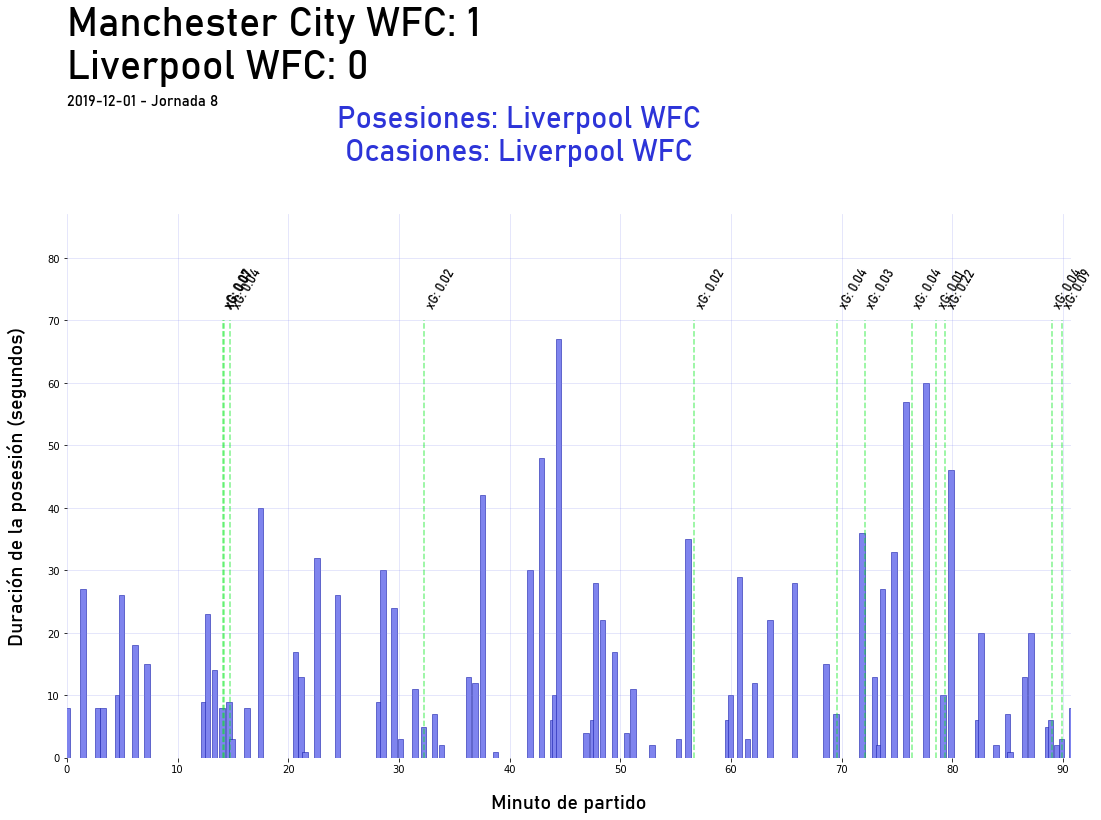

In [18]:
posconocasfavor(2275116,"Liverpool WFC")

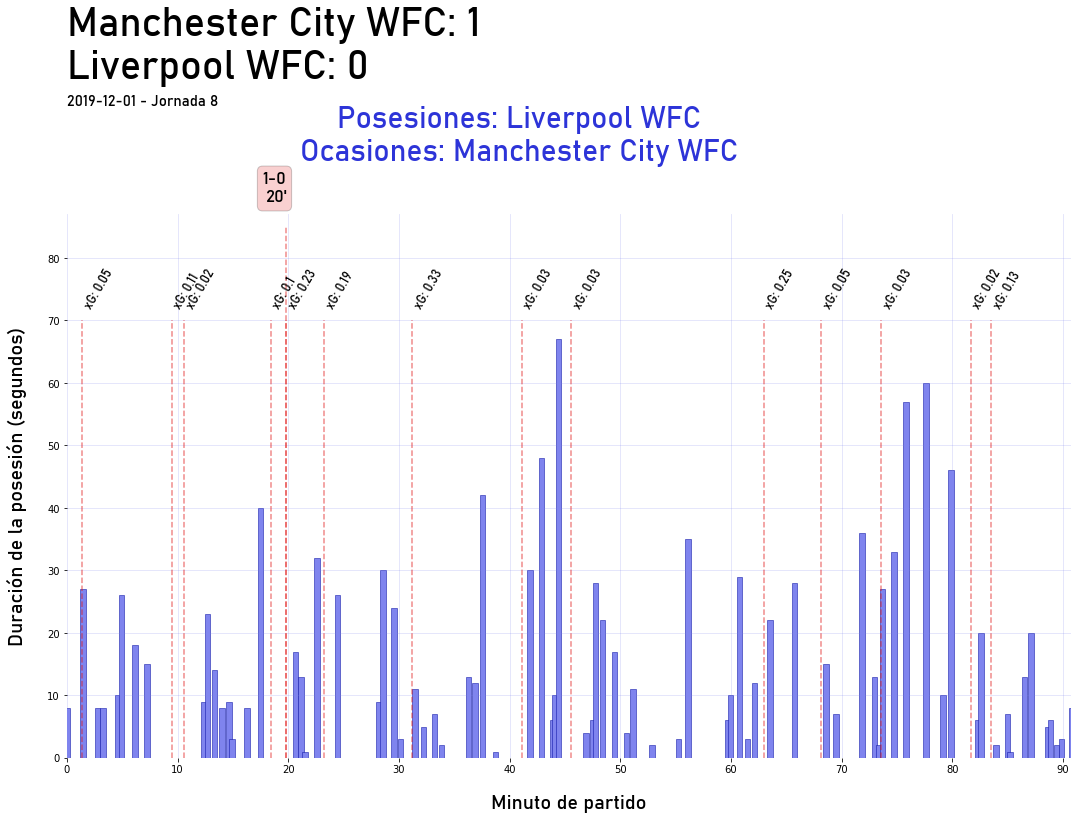

In [14]:
posconocascontra(2275116,"Liverpool WFC")